In [1]:
import os
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-04-27 14:02:23.779913: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 14:02:23.784101: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 14:02:23.841322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 14:02:24.780296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
image_size = (28, 28)
batch_size = 32

#testing

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "trafficsigns_dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 3681 files belonging to 5 classes.
Using 2945 files for training.
Using 736 files for validation.


2024-04-27 14:02:26.982296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


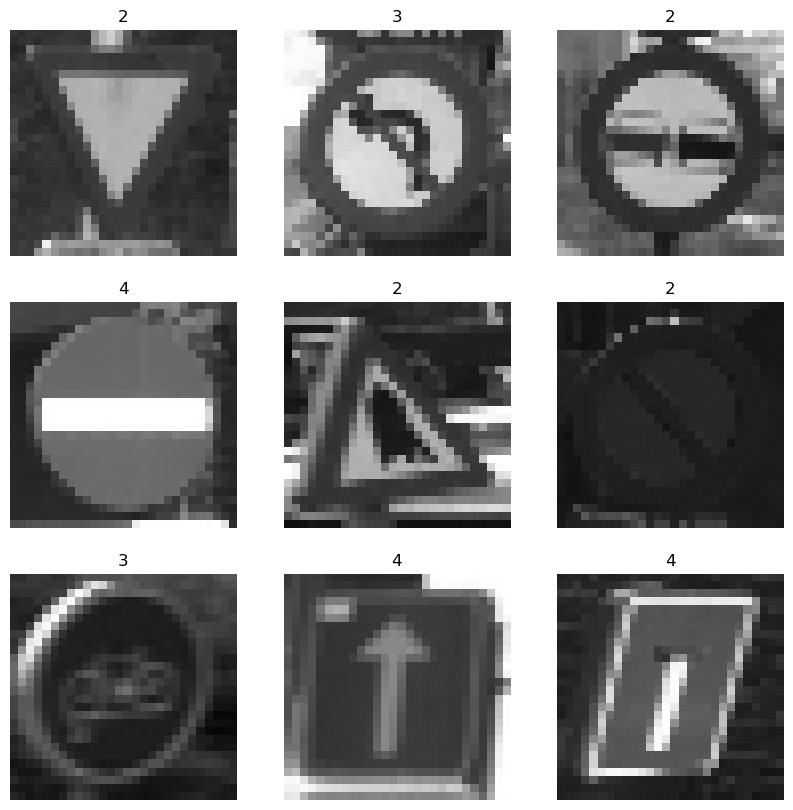

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [4]:
#indicates that even though the images look black and white, they're being treated as RGB
for images, labels in train_ds.take(1):
    print(images.shape) 

(32, 28, 28, 3)


2024-04-27 14:02:27.155623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


2024-04-27 14:02:27.860537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


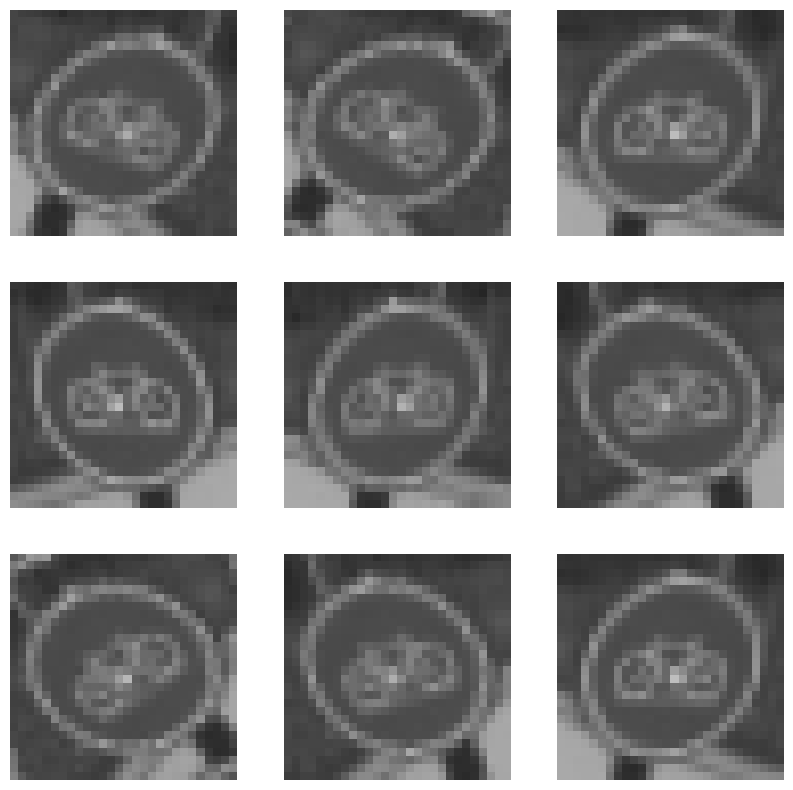

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


In [7]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)


In [8]:
pip install graphviz==0.20.3 --upgrade

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [32, 64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
        activation = 'sigmoid'
    else:
        units = num_classes
        activation = 'softmax'

    x = layers.Dropout(0.5)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

image_size = (28, 28)  # Spatial dimensions
model = make_model(input_shape=image_size + (3,), num_classes=8)  # Correctly adds the channel dimension

#model = make_model(input_shape=image_size + (1,), num_classes=8)
keras.utils.plot_model(model, show_shapes=True)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.3414 - loss: 6.4419 - val_accuracy: 0.4878 - val_loss: 2.1654
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3721 - loss: 3.7799 - val_accuracy: 0.4878 - val_loss: 2.2233
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3789 - loss: 3.0498 - val_accuracy: 0.4878 - val_loss: 2.2573
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3761 - loss: 2.9398 - val_accuracy: 0.3804 - val_loss: 2.2592
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3472 - loss: 2.5548 - val_accuracy: 0.3995 - val_loss: 2.2563
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3661 - loss: 2.5369 - val_accuracy: 0.4823 - val_loss: 2.2590
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3866 - loss: 2.5341 - val_accuracy: 0.4810 - val_loss: 2.2591
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3579 - loss: 2.4837 - val_accuracy: 0.4022 - v

In [12]:
# epochs = 10

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
# ]
# model.compile(
#     optimizer=keras.optimizers.Adam(3e-4),
#     loss=keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=[keras.metrics.BinaryAccuracy(name="acc")],
# )
# model.fit(
#     train_ds,
#     epochs=epochs,
#     callbacks=callbacks,
#     validation_data=val_ds,
# )


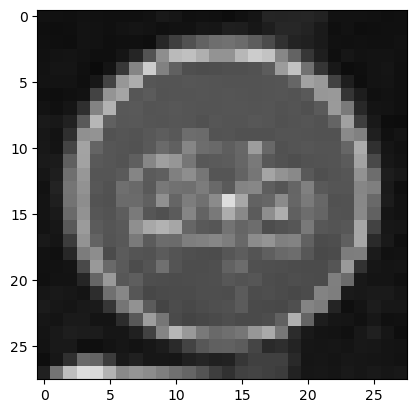

In [13]:
img = keras.utils.load_img("trafficsigns_dataset/round/bicycle/00004_00000.png", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

In [14]:

predictions = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


In [15]:
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)

Predicted class: [2]
